In [18]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, spearmanr
import glob
import matplotlib.pyplot as plt
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()

In [2]:
FPS = 60
INTERVAL_SIZE = 1
PD_STEP_SIZE = 10

In [3]:
trials_pd_paths = sorted(glob.glob("../new_exp_data/pd_summaries/pd_summaries/cv*tt*.rdata"))

trial_pds = []

for path in trials_pd_paths:
    r['load'](path)
    trial = r['df.ext']
    trial.frame = np.arange(10, 2710, 10).tolist() * 4
    trial_pds.append(trial)   

/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [4]:
mass_pd_list = []
force_pd_list = []

for trial_pd in trial_pds:
    
    window_size = int(FPS * INTERVAL_SIZE / PD_STEP_SIZE)
    pd_mass = trial_pd[["frame", "pd.mass.rtheta"]].groupby("frame").agg({"pd.mass.rtheta": np.mean})
    pd_mass = pd_mass["pd.mass.rtheta"].rolling(window=window_size).mean().values[window_size-1::window_size]
    mass_pd_list.append(pd_mass)

    pd_force = trial_pd[["frame", "pd.rel.rtheta"]].groupby("frame").agg({"pd.rel.rtheta": np.mean})
    pd_force = pd_force["pd.rel.rtheta"].rolling(window=window_size).mean().values[window_size-1::window_size]
    force_pd_list.append(pd_force)

In [5]:
confusing_force_intervals = pd.read_csv("cogsci_images/confusing_videos/"\
                                        "confusing_xy_vxvy/confusing_xy_vxvy_force_interval_description.csv")
confusing_mass_intervals = pd.read_csv("cogsci_images/confusing_videos/"\
                                       "confusing_xy_vxvy/confusing_xy_vxvy_mass_interval_description.csv")
obvious_force_intervals = pd.read_csv("cogsci_images/obvious_videos/"\
                                        "obvious_xy_vxvy/obvious_xy_vxvy_force_interval_description.csv")
obvious_mass_intervals = pd.read_csv("cogsci_images/obvious_videos/"\
                                       "obvious_xy_vxvy/obvious_xy_vxvy_mass_interval_description.csv")

In [6]:
confusing_mass_intervals.shape

(15, 7)

In [7]:
force_intervals = pd.concat([confusing_force_intervals, obvious_force_intervals])
force_intervals["is_obvious_interval"] = force_intervals["solution"] == force_intervals["rnn_preferred_option"]
mass_intervals = pd.concat([confusing_mass_intervals, obvious_mass_intervals])
mass_intervals["is_obvious_interval"] = mass_intervals["solution"] == mass_intervals["rnn_preferred_option"]

In [8]:
def get_average_pd_for_intervals(intervals, pd_list):
    pd_values = []
    
    for interval_i in range(intervals.shape[0]):
        interval = intervals.iloc[interval_i]
        trial_number = interval.trial_number
        window_start = interval.window_start
        window_end = interval.window_end
        pd_value = np.mean(pd_list[trial_number][window_start:window_end])
        pd_values.append(pd_value)
    return pd_values

In [28]:
def compute_correlations_and_plots(intervals, pd_list):

    average_pd = get_average_pd_for_intervals(intervals, pd_list)
    intervals["pd"] = average_pd

    print(ttest_ind(intervals.query("is_obvious_interval").pd, intervals.query("not is_obvious_interval").pd))
    print("Overall Correlation", np.corrcoef(intervals.rnn_solution_probability, intervals.pd)[0][1])
    print("Overall pearman", spearmanr(intervals.rnn_solution_probability, intervals.pd))

    markers = [".", "+", "*"]

    for i, solution in enumerate(intervals.solution.unique()):
        solution_intervals = intervals.query("solution == '%s'" % solution)
        plt.scatter(solution_intervals.rnn_solution_probability, solution_intervals.pd,
                    c=solution_intervals.is_obvious_interval, marker=markers[i], label=solution)

        print()
        print("Class: %s" % solution)
        print("Class Correlation", np.corrcoef(solution_intervals.rnn_solution_probability, solution_intervals.pd)[0][1])
        print("Class Spearman", spearmanr(solution_intervals.rnn_solution_probability, solution_intervals.pd))
    plt.legend()
    plt.show()

Ttest_indResult(statistic=4.121846735585153, pvalue=0.0003028405621888076)
Overall Correlation 0.7722856183511214
Overall pearman SpearmanrResult(correlation=0.7842046718576196, pvalue=2.939055421351856e-07)

Class: attract
Class Correlation 0.9315423280308686
Class Spearman SpearmanrResult(correlation=0.8787878787878788, pvalue=0.0008138621117322101)

Class: repel
Class Correlation 0.22224682703013898
Class Spearman SpearmanrResult(correlation=0.24848484848484845, pvalue=0.48877630451924314)

Class: none
Class Correlation 0.7087823467469362
Class Spearman SpearmanrResult(correlation=0.8787878787878788, pvalue=0.0008138621117322101)


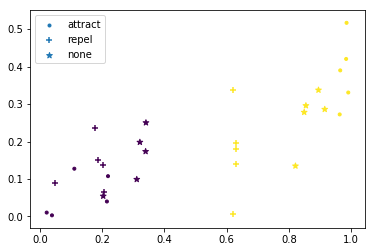

Ttest_indResult(statistic=1.3867359448091099, pvalue=0.17646467241829622)
Overall Correlation 0.14464957266479328
Overall pearman SpearmanrResult(correlation=0.17997775305895441, pvalue=0.34125235482307215)

Class: A
Class Correlation 0.09584557109468705
Class Spearman SpearmanrResult(correlation=0.2121212121212121, pvalue=0.5563057751029299)

Class: B
Class Correlation 0.11459994950489528
Class Spearman SpearmanrResult(correlation=0.32121212121212117, pvalue=0.3654683104386702)

Class: same
Class Correlation 0.4889423473050163
Class Spearman SpearmanrResult(correlation=0.3696969696969697, pvalue=0.2930500752928223)


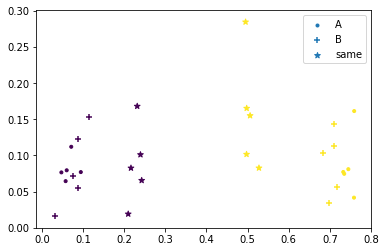

In [29]:
compute_correlations_and_plots(force_intervals, force_pd_list)
compute_correlations_and_plots(mass_intervals, mass_pd_list)